In [1]:
import pandas as pd
import category_encoders as ce
import numpy as np
import datetime
from collections import Counter
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split # для разделения датасета
from sklearn import preprocessing
import warnings 
warnings.filterwarnings('ignore') 

#для эмоциональности текста
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

# библиотеки для визуализации 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
# исходник 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# фиксируем RANDOM_SEED, для воспроизводимости эксперимента
RANDOM_SEED = 42

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

## Исследование данных

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # данные для обучения
df_test['sample'] = 0 # данные для теста
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

df = pd.concat([df_test, df_train], ignore_index=True, sort=False)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
df.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [14]:
df.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [15]:
df.describe(include = 'object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


In [16]:
df.nunique() # смотрим на кол-во уникальных признаков

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64

In [17]:
# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['additional_number_of_scoring' 'average_score'
 'review_total_negative_word_counts' 'total_number_of_reviews'
 'review_total_positive_word_counts'
 'total_number_of_reviews_reviewer_has_given' 'lat' 'lng' 'sample'
 'reviewer_score']
['hotel_address' 'review_date' 'hotel_name' 'reviewer_nationality'
 'negative_review' 'positive_review' 'tags' 'days_since_review']


array([[<Axes: title={'center': 'additional_number_of_scoring'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>,
        <Axes: title={'center': 'reviewer_score'}>]], dtype=object)

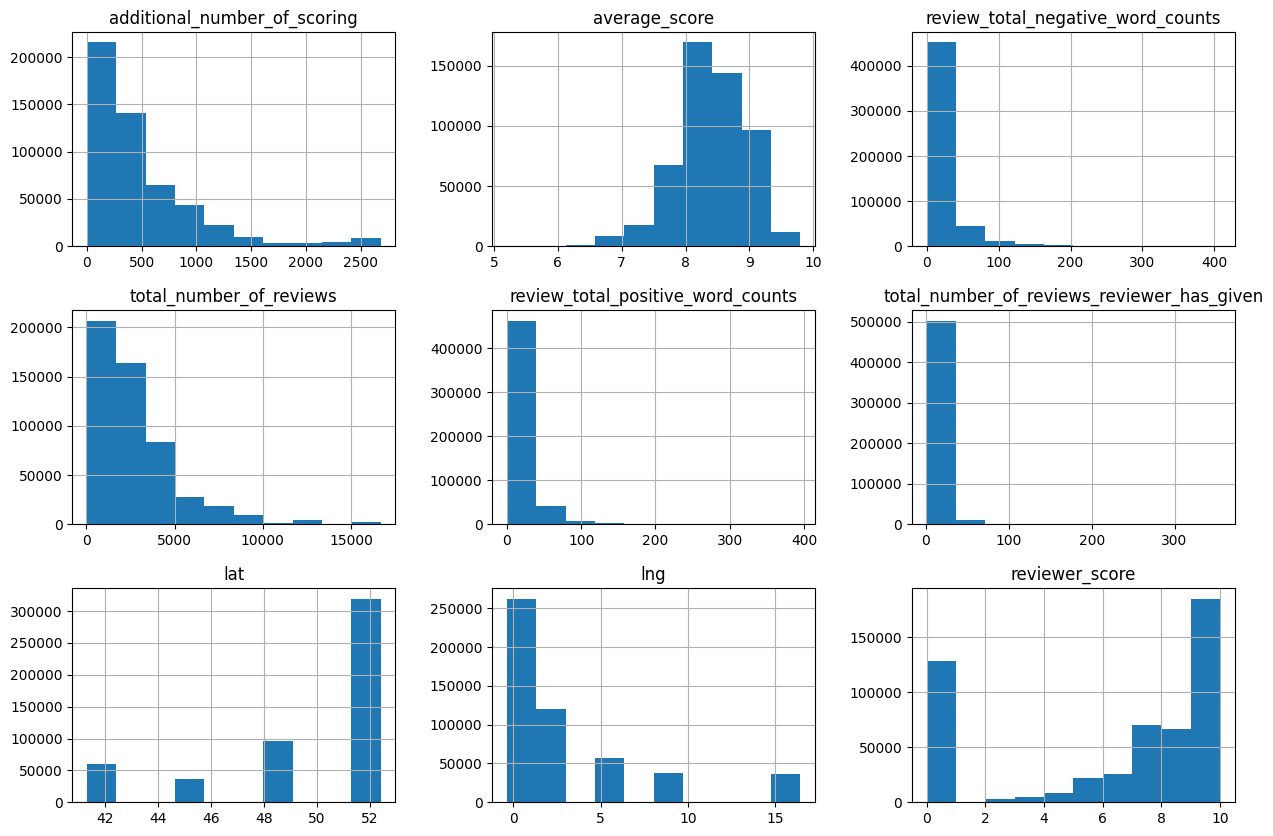

In [18]:
# построим распеределение всех возможных признаков быстрой просто визуализацией
hist = df.drop(['sample'], axis=1).hist(figsize=(15,10));
hist

Проведем небольшое исследование зависимости целевого признака reviewer_score от числовых признаков.
Для каждого числового признака построим гистограмму признака и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов.

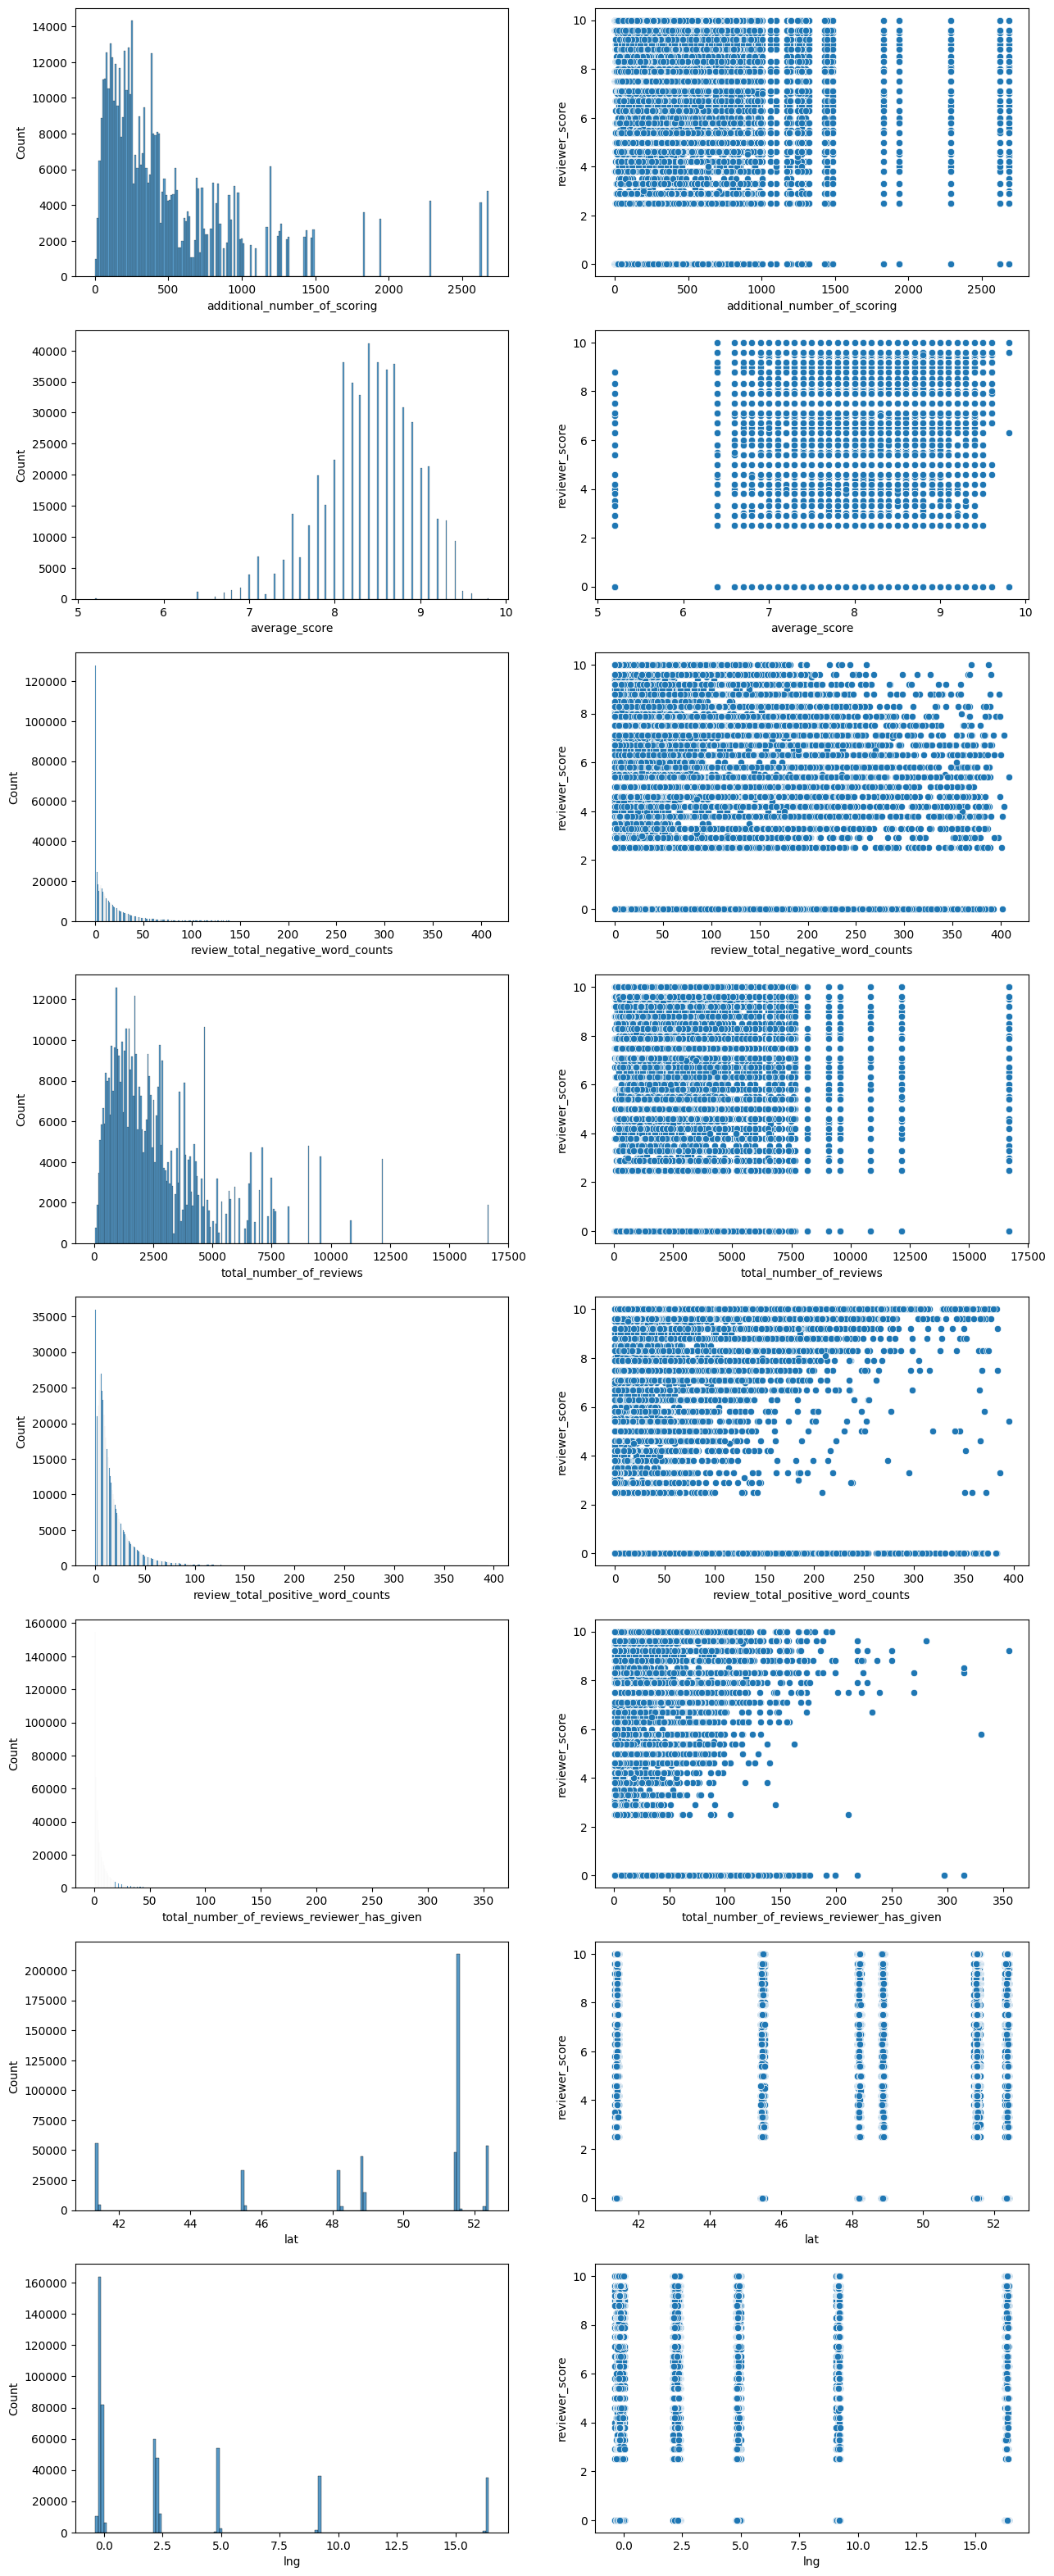

In [19]:
fig, axes = plt.subplots(8, 2, figsize=(15, 40))

hist1 = sns.histplot(df[df['sample']==1],x=df['additional_number_of_scoring'],ax=axes[0][0])
hist2 = sns.histplot(df[df['sample']==1],x=df['average_score'],ax=axes[1][0])
hist3 = sns.histplot(df[df['sample']==1],x=df['review_total_negative_word_counts'],ax=axes[2][0])
hist4 = sns.histplot(df[df['sample']==1],x=df['total_number_of_reviews'],ax=axes[3][0])
hist5 = sns.histplot(df[df['sample']==1],x=df['review_total_positive_word_counts'],ax=axes[4][0])
hist6 = sns.histplot(df[df['sample']==1],x=df['total_number_of_reviews_reviewer_has_given'],ax=axes[5][0])
hist7 = sns.histplot(df[df['sample']==1],x=df['lat'],ax=axes[6][0])
hist8 = sns.histplot(df[df['sample']==1],x=df['lng'],ax=axes[7][0])

scat1 = sns.scatterplot(df[df['sample']==1],x=df['additional_number_of_scoring'],y=df['reviewer_score'], ax=axes[0][1])
scat2 = sns.scatterplot(df[df['sample']==1],x=df['average_score'],y=df['reviewer_score'], ax=axes[1][1])
scat3 = sns.scatterplot(df[df['sample']==1],x=df['review_total_negative_word_counts'],y=df['reviewer_score'], ax=axes[2][1])
scat4 = sns.scatterplot(df[df['sample']==1],x=df['total_number_of_reviews'],y=df['reviewer_score'], ax=axes[3][1])
scat5 = sns.scatterplot(df[df['sample']==1],x=df['review_total_positive_word_counts'],y=df['reviewer_score'], ax=axes[4][1])
scat6 = sns.scatterplot(df[df['sample']==1],x=df['total_number_of_reviews_reviewer_has_given'],y=df['reviewer_score'], ax=axes[5][1])
scat7 = sns.scatterplot(df[df['sample']==1],x=df['lat'],y=df['reviewer_score'], ax=axes[6][1])
scat8 = sns.scatterplot(df[df['sample']==1],x=df['lng'],y=df['reviewer_score'], ax=axes[7][1])

Сразу можно выделить три признака:

* 'average_score'-  зависимость от целевого признака практически прямая, поэтому будем использовать это признак для целей подготовки данных.

* 'review_total_negative_word_counts' и 'review_total_positive_word_counts' - также имеют сильную зависимость от целевого признака.Прослеживается влияние этих признаков на целевой, возможно, чем больше количество слов в неативном отзыве, тем ниже оценка и также для позитивных, чем больше слов в позитивном отзыве, тем выше оценка.

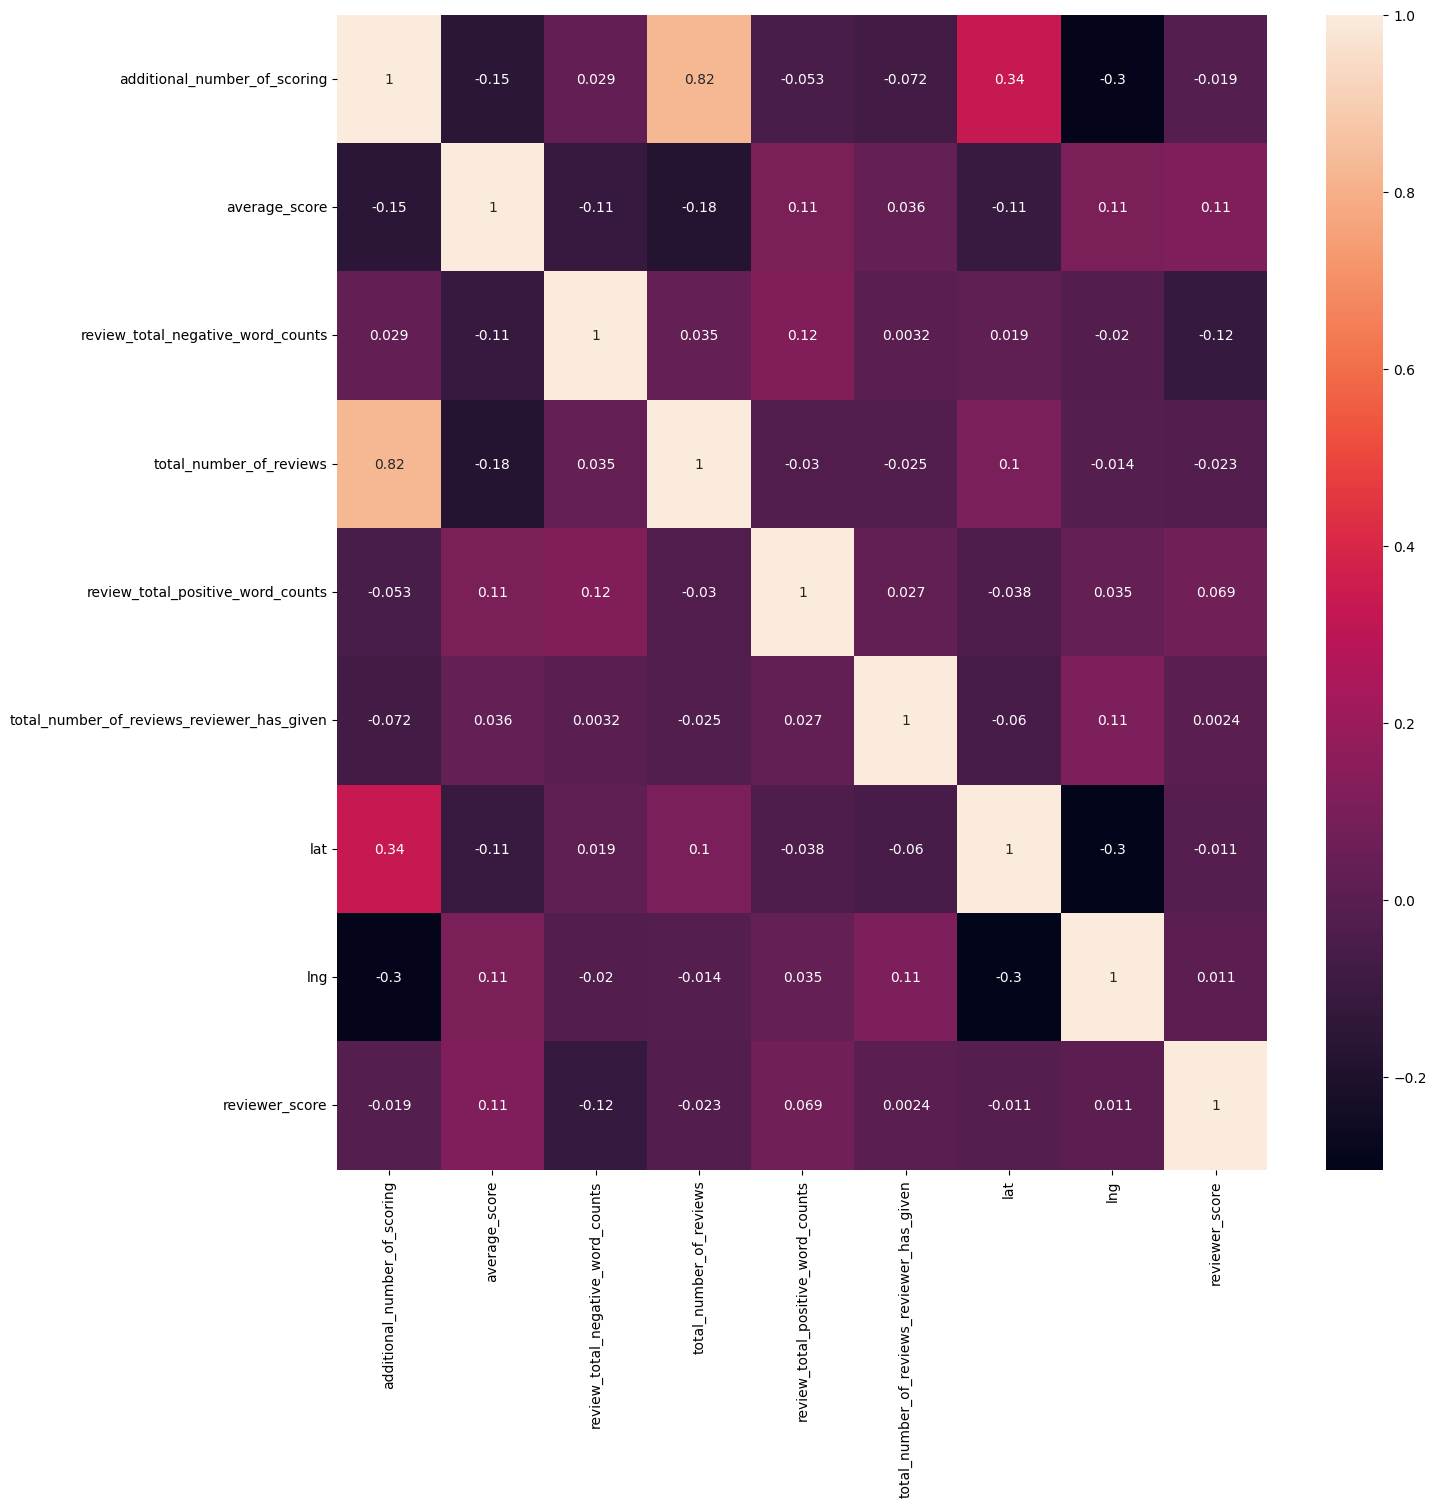

In [20]:
fig, axes = plt.subplots(figsize=(15, 15))
sns.heatmap(df.drop(['sample'], axis=1).corr(numeric_only=True), annot=True);

## 2. Подготовка данных

#### **Находим пропуски и збавляемся от них**

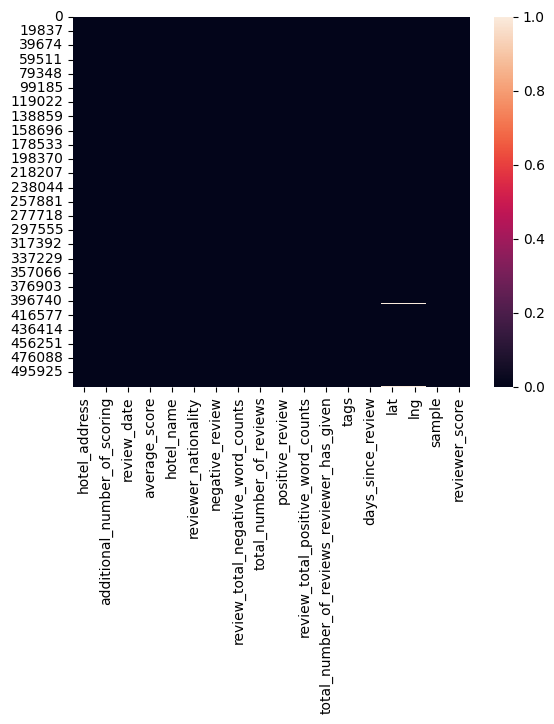

In [21]:
sns.heatmap(df.isnull()); # наглядная карта пропусков

Убеждаемся, что пропуски в 'lat идентичны пропускам в 'lng'.

In [22]:
# создадим справочный фрейм для геокоординат отелей (пока с нулями)
df_cor = df[df['lat'].isnull()].groupby('hotel_address').count()[['lat', 'lng']]
df_cor

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,0,0
23 Rue Damr mont 18th arr 75018 Paris France,0,0
4 rue de la P pini re 8th arr 75008 Paris France,0,0
Bail n 4 6 Eixample 08010 Barcelona Spain,0,0
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,0,0
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,0,0
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,0,0
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,0,0
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,0,0


In [23]:
# напишем список с координатами по каждому из отелей в порядке расположения отелей в справочном фрейме 
# (их всего 17 и можно не использовать доп.ресурсы) 

lst_geo = [[48.8399957, 2.3070823], 
           [48.8889127, 2.3309643], 
           [48.8753208, 2.3212033], 
           [41.391552, 2.1757053],
           [48.2208555, 16.3644228],
           [48.233592, 16.3434781],
           [48.2094054, 16.3512565],
           [48.2095525, 16.3492746],
           [48.1888183, 16.381591],
           [48.1868142, 16.418528],
           [41.3749946, 2.1102353],
           [48.219573, 16.2834034],
           [41.3832425, 2.1607609],
           [48.2458909, 16.3397395],
           [48.2135906, 16.3777195],
           [48.2168032, 16.357717],
           [48.220414, 16.3536299]]

In [24]:
# заполним справочный фрейм координатами
for i in range (17):
    df_cor.iloc[i] = lst_geo[i]
df_cor

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.220855,16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.233592,16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.209405,16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.209553,16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.188818,16.381591


In [25]:
# теперь осталось дополнить координатами  из справочного фрейма наш основной датафрейм
df = df.set_index('hotel_address')
df.update(df_cor)
df = df.reset_index()

In [26]:
df.info()#проверяем отсутствие пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

#### **Проверяем данные на наличие дубликатов**

In [27]:
df[df.duplicated ()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
26726,Scarsdale Place Kensington Kensington and Chel...,1831,11/8/2016,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,No Negative,0,7105,Location Breakfast,3,11,"[' Business trip ', ' Couple ', ' Standard Dou...",268 day,51.499046,-0.191707,0,0.0
49098,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/16/2017,7.9,H tel Concorde Montparnasse,United States of America,No Negative,0,2515,Good location for late night arrival by train...,29,2,"[' Leisure trip ', ' Family with young childre...",18 days,48.838108,2.318669,0,0.0
49541,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,4/9/2017,7.9,H tel Concorde Montparnasse,Lebanon,Elevator needs restoration Cleaning,5,2515,No Positive,0,12,"[' Leisure trip ', ' Solo traveler ', ' Classi...",116 day,48.838108,2.318669,0,0.0
50267,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,3/20/2016,9.0,H tel Baume,United States of America,No Negative,0,253,Great location Very pleasant clean and modern...,12,13,"[' Leisure trip ', ' Family with older childre...",501 day,48.850152,2.339278,0,0.0
51878,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/5/2017,7.9,H tel Concorde Montparnasse,Belgium,Absence of a proper fridge what they call min...,25,2515,Very comfy beds friendly and efficient recept...,9,9,"[' Leisure trip ', ' Solo traveler ', ' Classi...",29 days,48.838108,2.318669,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512039,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,11/3/2015,9.0,H tel Baume,United States of America,Rooms are very small,6,253,Location is excellent and staff is very frien...,10,1,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",639 day,48.850152,2.339278,1,8.3
512118,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/28/2016,7.9,H tel Concorde Montparnasse,France,A bit noisy old fashion At almost 20 the brea...,18,2515,Convenient if one arrives departs from the Mo...,10,48,"[' Business trip ', ' Solo traveler ', ' Class...",371 day,48.838108,2.318669,1,6.7
512733,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/15/2017,7.9,H tel Concorde Montparnasse,United Kingdom,twice spoken to staff to replace the coffee w...,24,2515,Tea making facilities not in the room only co...,11,2,"[' Leisure trip ', ' Couple ', ' Superior Doub...",80 days,48.838108,2.318669,1,7.9
513053,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,10/12/2015,7.9,H tel Concorde Montparnasse,Australia,No great restaurants within a short walk but ...,12,2515,The Hotel was wonderfully p laced for us to a...,44,24,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",661 day,48.838108,2.318669,1,10.0


Данные дублируются, но не по всем стобцам. Удалять не будем.

#### **Разбираем признаки**

* *Признак 'hotel_address' (адрес отеля)*

In [28]:
#выделим признак страны из адреса
df['country'] = df['hotel_address'].apply(
    lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else 'UK')

# выделяем город
df['hotel_city'] = df['hotel_address'].apply(lambda x: x.split()[-2])
# находим правильный город в United Kingdom
df.loc[df['hotel_city'] == 'United', 'hotel_city'] = df['hotel_address'].apply(lambda x: x.split()[-5])

In [29]:
# проверяем, что данные по стране и городу идентичны
df[['country', 'hotel_city']].value_counts()

country      hotel_city
UK           London        262301
Spain        Barcelona      60149
France       Paris          59928
Netherlands  Amsterdam      57214
Austria      Vienna         38939
Italy        Milan          37207
Name: count, dtype: int64

In [30]:
df.drop(columns= ['country','hotel_address'], inplace=True)

In [31]:
#закодируем признак города
df = pd.get_dummies(df, columns=['hotel_city'])

Так как данные по стране и городу идентичны, оставим только признак города и закодируем его.

* *Признак 'review_date' (дата оставления отзыва)*

Приведем признак 'review_date' к формату - datetime. Выделим новые признаки - год, месяц, квартал, день недели. Проанализируем влияние новых признаков на признак 'reviewer_score'

In [32]:
#Разбор даты
df['review_date']=pd.to_datetime(df['review_date'])
df['year'] = df['review_date'].dt.year
df['quarter'] = df['review_date'].dt.quarter
df['month'] = df['review_date'].dt.month
df['dayofweek'] = df['review_date'].dt.dayofweek

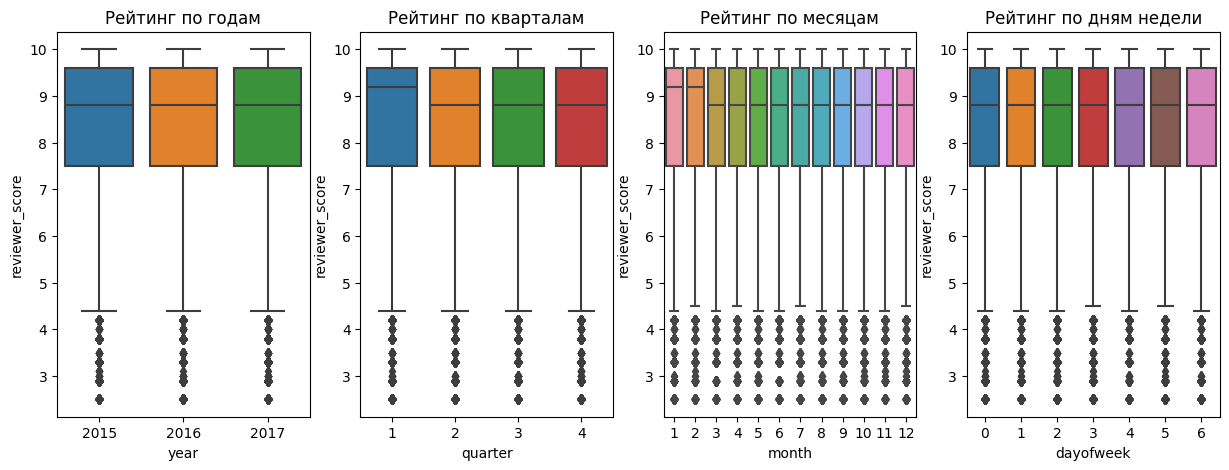

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(15,5))

bx1 = sns.boxplot(data=df[df['sample']==1],y='reviewer_score',x='year',ax=axes[0])
bx1.set_title('Рейтинг по годам');
bx2= sns.boxplot(data=df[df['sample']==1],y='reviewer_score',x='quarter',ax=axes[1])
bx2.set_title('Рейтинг по кварталам');
bx3 = sns.boxplot(data=df[df['sample']==1],y='reviewer_score', x='month',ax=axes[2])
bx3.set_title('Рейтинг по месяцам');
bx3 = sns.boxplot(data=df[df['sample']==1],y='reviewer_score', x='dayofweek',ax=axes[3])
bx3.set_title('Рейтинг по дням недели');

In [34]:
#закодируем признак квартала
df = pd.get_dummies(df, columns=['year','quarter','month','dayofweek'])

Графики распределения оценок в разрезе лет существенно не отличаются, можем предположить, что год выставления оценки не влияет на размер, т.е. этот признак не является значимым.
Визуально, средняя оценка выше при оценке в первые три месяца года, и не отличается для остальных месяцев, то есть в первый квартал года. Выделим признак квартала.

* *Признак 'days_since_review* 

In [35]:
# Преобразуем c помощью функции признак «days_since_review» в хронологический порядок 
df['days_since_review'] \
    = df['days_since_review'].apply(lambda x: int(x.split()[0]))
df['day_number'] \
    = (df['days_since_review'] - df['days_since_review'].max()) * (-1)

* *Признак 'reviewer_nationality' (национальность рецензента)*

Создадим ТОП-10 популярных национальностей, остальные пометим как 'other'. Проанализируем влияние признака на целевой показатель.

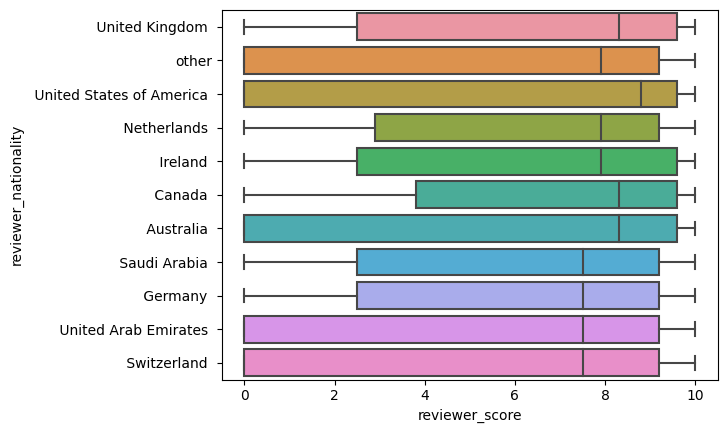

In [36]:
pop_nationality = df['reviewer_nationality'].value_counts().nlargest(10).index
df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x if x in pop_nationality else 'other')
#round(df['reviewer_nationality'].value_counts(normalize=True),2)

boxplot = sns.boxplot(data=df, x='reviewer_score',y='reviewer_nationality')

In [37]:
encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True) # указываем столбец для кодирования
nutional_bin = encoder.fit_transform(df['reviewer_nationality'])
df = pd.concat([df, nutional_bin], axis=1)

На графике распределения оценок в разрезе национальности видно, что средняя оценка отличается, то есть этот признак вероятно влияет на выставляемую оценку.

In [38]:
# Группировка данных по рецензенту и вычисление среднего количества отзывов
reviewer_avg_reviews = df.groupby('reviewer_nationality')['total_number_of_reviews_reviewer_has_given'].mean()

# Создание нового столбца 'avg_reviews_per_reviewer' и заполнение средними значениями
df['avg_reviews_per_reviewer'] = df['reviewer_nationality'].map(reviewer_avg_reviews)

# Вывод среднего значения для всего датасета
print("Среднее количество отзывов на одного рецензента:", df['avg_reviews_per_reviewer'].mean())

Среднее количество отзывов на одного рецензента: 7.1660009539727545


* *Признак 'tags'*

In [39]:
# Посмотрим что у нас творится с тагами, какая информация там скрывается
tags = set()
tags_list = list()
for index, value in df['tags'].items():
        pre_tags = value
        pre_tags = pre_tags.replace('[', '').replace(']', '')
        pre_tags = pre_tags.replace("'", '')
        pre_tags = pre_tags.split(",")
        for i in pre_tags:
            tags.add(i.strip())
            tags_list.append(i.strip())

# Подсчитываем количество уникальных тегов
unique_tags_count = len(tags)
tags_list_count = len(tags_list)
print("Количество уникальных тегов:", unique_tags_count)
print("Всего тeгов:", tags_list_count)  

Количество уникальных тегов: 2428
Всего тeгов: 2356592


In [40]:
# Посмотрим на самые популярные тeги
tags_series = pd.Series(
    data = tags_list,
    index = tags_list,
    name = 'tags_series'
)

print(tags_series.value_counts()[:10]) 

tags_series
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: count, dtype: int64


In [41]:
# для начала сделаем признак удобным для дальнейшей работы
df.tags = df.tags.apply(lambda x: x[3:-3].split(" ', ' "))

In [42]:
#сохраним наиболее часто встречающиеся тэги
top_of_tags = df['tags'].explode().value_counts().head(10).index
top_of_tags

Index(['Leisure trip', 'Submitted from a mobile device', 'Couple',
       'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights',
       'Business trip', 'Group', 'Family with young children'],
      dtype='object', name='tags')

In [43]:
#создадим признаки для наиболее часто встречающихся тэгов
for tag in top_of_tags:
    df['tag_'+ tag] = df['tags'].apply(
        lambda x: 1 if tag in x else 0
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 72 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   additional_number_of_scoring                     515738 non-null  int64         
 1   review_date                                      515738 non-null  datetime64[ns]
 2   average_score                                    515738 non-null  float64       
 3   hotel_name                                       515738 non-null  object        
 4   reviewer_nationality                             515738 non-null  object        
 5   negative_review                                  515738 non-null  object        
 6   review_total_negative_word_counts                515738 non-null  int64         
 7   total_number_of_reviews                          515738 non-null  int64         
 8   positive_review         

In [44]:
# получим продолжительности пребывания.
# заполним значений NaN типичной продолжительностью пребывания в 1 день.
def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

df['night_index'] = df['tags'].apply(get_stay)
df['night_index'].fillna(1, inplace=True)

Создание новых признаков из признаков 'negative_review' и 'positive_review

In [45]:
# удалимм 'No Negative' или 'No Positive' из текста
df['negative_review'] = df['negative_review'].apply(lambda x: x.replace("No Negative", ""))
df['positive_review'] = df['positive_review'].apply(lambda x: x.replace("No Positive", ""))

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
df['negative_sentiments'] = df['negative_review'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['positive_sentiments'] = df['positive_review'].apply(lambda x: sid.polarity_scores(x)['compound'])
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,tag_Stayed 1 night,tag_Stayed 2 nights,tag_Solo traveler,tag_Stayed 3 nights,tag_Business trip,tag_Group,tag_Family with young children,night_index,negative_sentiments,positive_sentiments
0,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,0,0,0,0,0,2.0,-0.0554,0.9615
1,612,2016-12-12,8.6,Urban Lodge Hotel,other,No tissue paper box was present at the room,10,5018,,0,...,1,0,0,0,0,1,0,1.0,-0.2960,0.0000
2,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,other,Pillows,3,351,Nice welcoming and service,5,...,1,0,1,0,1,0,0,1.0,0.0000,0.6908
3,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,,0,1543,Everything including the nice upgrade The Hot...,27,...,1,0,0,0,0,0,0,1.0,0.0000,0.9153
4,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,,0,4687,Lovely hotel v welcoming staff,7,...,0,1,1,0,1,0,0,2.0,0.0000,0.7717


In [47]:
#преобразуем признак negative_review в список слов 
df['negative_review'] = df['negative_review'].apply(
    lambda x: x.lower().split()
)
df['negative_review'].head()

0    [would, have, appreciated, a, shop, in, the, h...
1    [no, tissue, paper, box, was, present, at, the...
2                                            [pillows]
3                                                   []
4                                                   []
Name: negative_review, dtype: object

In [48]:
from nltk.corpus import stopwords


stop_words = set(stopwords.words('english'))
df['negative_review'] = df['negative_review'].apply(
    lambda x: [token for token in x if token not in stop_words]
)


df['negative_review'].head()

0    [would, appreciated, shop, hotel, sold, drinki...
1                  [tissue, paper, box, present, room]
2                                            [pillows]
3                                                   []
4                                                   []
Name: negative_review, dtype: object

In [49]:
#посмотрим наиболее часто встречающиеся слова
df_negative = pd.DataFrame(
    df[df['review_total_negative_word_counts'] > 0]['negative_review'].explode()
)
df_negative['negative_review'].value_counts().head(20)

negative_review
room         176026
hotel         74709
breakfast     58478
small         49880
staff         39512
nothing       38768
rooms         34802
would         32291
could         32079
bed           29828
one           28095
bit           27546
bathroom      26585
night         24063
little        22536
like          22445
shower        21290
good          20821
us            20225
get           19504
Name: count, dtype: int64

In [50]:
#заполним список часто встречающихся слов в негативном отзыве
top_negative_words = df_negative['negative_review'].value_counts().head(20).index

In [51]:
#создадим признаки для наиболее часто встречающихся слов в negative_review
for negative_review in top_negative_words:
    df['negative_'+ negative_review] = df['negative_review'].apply(
        lambda x: 1 if negative_review in x else 0
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 95 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   additional_number_of_scoring                     515738 non-null  int64         
 1   review_date                                      515738 non-null  datetime64[ns]
 2   average_score                                    515738 non-null  float64       
 3   hotel_name                                       515738 non-null  object        
 4   reviewer_nationality                             515738 non-null  object        
 5   negative_review                                  515738 non-null  object        
 6   review_total_negative_word_counts                515738 non-null  int64         
 7   total_number_of_reviews                          515738 non-null  int64         
 8   positive_review         

In [52]:
#преобразуем признак positive_review в список слов 
df['positive_review'] = df['positive_review'].apply(
    lambda x: x.lower().split()
)
df['positive_review'].head()

0    [hotel, was, great, clean, friendly, staff, fr...
1                                                   []
2                      [nice, welcoming, and, service]
3    [everything, including, the, nice, upgrade, th...
4                 [lovely, hotel, v, welcoming, staff]
Name: positive_review, dtype: object

In [53]:
df['positive_review'] = df['positive_review'].apply(
    lambda x: [token for token in x if token not in stop_words]
)

df['positive_review'].head()

0    [hotel, great, clean, friendly, staff, free, b...
1                                                   []
2                           [nice, welcoming, service]
3    [everything, including, nice, upgrade, hotel, ...
4                 [lovely, hotel, v, welcoming, staff]
Name: positive_review, dtype: object

In [54]:
#посмотрим наиболее часто встречающиеся слова
df_negative = pd.DataFrame(
    df[df['review_total_positive_word_counts'] > 0]['positive_review'].explode()
)
df_negative['positive_review'].value_counts().head(20)

positive_review
staff          194574
location       192856
room           140746
hotel          125326
good           112321
great          105641
friendly        85353
breakfast       84581
helpful         76183
nice            69449
clean           66929
excellent       62272
comfortable     59952
bed             49926
rooms           40370
lovely          35096
stay            32031
close           30971
station         29312
really          28224
Name: count, dtype: int64

In [55]:
top_positive_words = df_negative['positive_review'].value_counts().head(20).index
top_positive_words

Index(['staff', 'location', 'room', 'hotel', 'good', 'great', 'friendly',
       'breakfast', 'helpful', 'nice', 'clean', 'excellent', 'comfortable',
       'bed', 'rooms', 'lovely', 'stay', 'close', 'station', 'really'],
      dtype='object', name='positive_review')

In [56]:
#создадим признаки для наиболее часто встречающихся слов в positive_review
for positive_review in top_positive_words:
    df['positive_'+ positive_review] = df['positive_review'].apply(
        lambda x: 1 if positive_review in x else 0
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 115 entries, additional_number_of_scoring to positive_really
dtypes: bool(32), datetime64[ns](1), float64(8), int64(69), object(5)
memory usage: 342.3+ MB


## Нормализация признаков

In [57]:
#проведем стандартизацию/нормализацию для числовых признаков
num_cols = ['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'lat',
       'lng','days_since_review']

In [58]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

In [59]:
#проверим распределение числовых признаков на нормальность с помощью теста Шапиро — Уилка

for col in num_cols:
    print('Признак ' + col)
    result = stats.shapiro(df[col])
    decision_normality(result[1])

Признак additional_number_of_scoring
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак average_score
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак review_total_negative_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак total_number_of_reviews
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак review_total_positive_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак total_number_of_reviews_reviewer_has_given
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак lat
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от норм

Так как все признаки распределены не нормально, используем нормализацию для преобразования. Будем использовать нормализатор RobustScaler, так как мы не выполняли очистку данных

In [60]:
from sklearn import preprocessing

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
df[num_cols] = r_scaler.fit_transform(df[num_cols])

In [61]:
df[num_cols].head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,days_since_review
0,1.146640,-0.428571,2.047619,5.928222,3.000000,-0.285714,-1.806918,1.835922,-0.965909
1,0.551935,0.285714,0.047619,1.176183,-0.647059,0.571429,0.268204,0.965899,-0.338068
2,-0.600815,-0.142857,-0.285714,-0.727162,-0.352941,1.714286,-3.060602,0.429656,0.747159
3,-0.203666,1.000000,-0.428571,-0.241028,0.941176,0.857143,-1.823043,1.840977,0.860795
4,1.004073,1.000000,-0.428571,1.041191,-0.235294,-0.142857,0.263630,0.976773,0.258523


## Отбор признаков

In [62]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df.columns if df[s].dtypes == 'object' or df[s].dtypes == 'category' or df[s].dtypes == 'datetime64[ns]']
df.drop(object_columns, axis = 1, inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 109 entries, additional_number_of_scoring to positive_really
dtypes: bool(32), float64(14), int64(63)
memory usage: 318.7 MB


<Axes: >

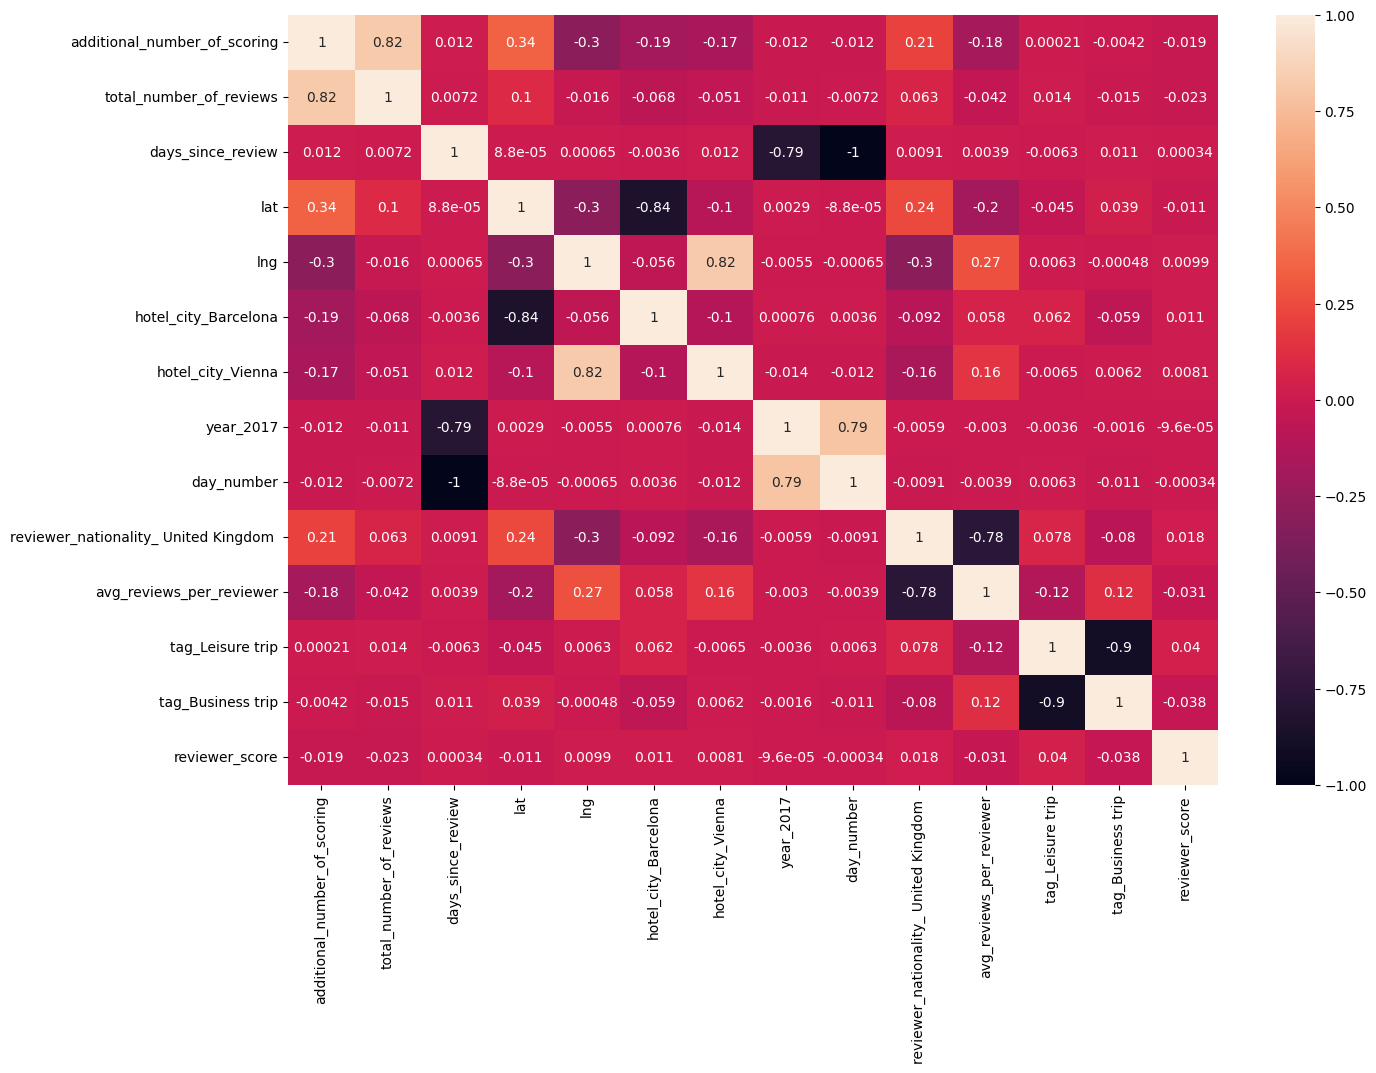

In [64]:
df_corr = df.drop(['sample'], axis=1).corr()
result_columns = []
for column in df_corr:
    col_data = df_corr[column]
    if col_data.min() < -0.7 or col_data.sort_values(ascending=False)[1] > 0.7:
        result_columns.append(column)
result_columns.append('reviewer_score')
        
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df[result_columns].corr(), annot=True)

In [65]:
# рассмотрим признаки, между которыми наблюдается сильная связь
for row in df_corr.index:
    for col in df_corr.columns:
        if df_corr.loc[row, col] != 1 and abs(df_corr.loc[row, col]) >= 0.7:
            print(row, col, '-', round(abs(df_corr.loc[row, col]), 3))

additional_number_of_scoring total_number_of_reviews - 0.825
total_number_of_reviews additional_number_of_scoring - 0.825
days_since_review year_2017 - 0.791
days_since_review day_number - 1.0
lat hotel_city_Barcelona - 0.845
lng hotel_city_Vienna - 0.825
hotel_city_Barcelona lat - 0.845
hotel_city_Vienna lng - 0.825
year_2017 days_since_review - 0.791
year_2017 day_number - 0.791
day_number days_since_review - 1.0
day_number year_2017 - 0.791
reviewer_nationality_ United Kingdom  avg_reviews_per_reviewer - 0.781
avg_reviews_per_reviewer reviewer_nationality_ United Kingdom  - 0.781
tag_Leisure trip tag_Business trip - 0.904
tag_Business trip tag_Leisure trip - 0.904


#### Анализ признаков с мультиколлинеарностью:

* additional_number_of_scoring и total_number_of_reviews. Оставляем  total_number_of_reviewsб данные в этих признаках похожи, это может навредить модели.

* 'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Milan', 'city_Paris', 'city_Vienna' и lng,lat. Оставляем координаты, тк они точно определяют место отеля.

* year_2015, year_2016, year_2017 и days_since_review и day_number. Удаляем признак года, тк он не является информативным и имеет высокую корреляцию с этими признаками

* days_since_review и day_number. Оставляем признак days_since_review.

In [66]:
df.drop(columns= [
    'additional_number_of_scoring', 'hotel_city_Amsterdam', 'hotel_city_Barcelona',
    'hotel_city_London', 'hotel_city_Milan', 'hotel_city_Paris',
    'hotel_city_Vienna','year_2015','year_2016', 'year_2017','day_number'   
], inplace=True)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 98 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   average_score                                    515738 non-null  float64
 1   review_total_negative_word_counts                515738 non-null  float64
 2   total_number_of_reviews                          515738 non-null  float64
 3   review_total_positive_word_counts                515738 non-null  float64
 4   total_number_of_reviews_reviewer_has_given       515738 non-null  float64
 5   days_since_review                                515738 non-null  float64
 6   lat                                              515738 non-null  float64
 7   lng                                              515738 non-null  float64
 8   sample                                           515738 non-null  int64  
 9   reviewer_score 

## Обучение модели и предсказание

In [68]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [69]:
%%time
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


MAPE: 0.12052039376025801
CPU times: user 19min 41s, sys: 4.76 s, total: 19min 46s
Wall time: 5min 6s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


<Axes: >

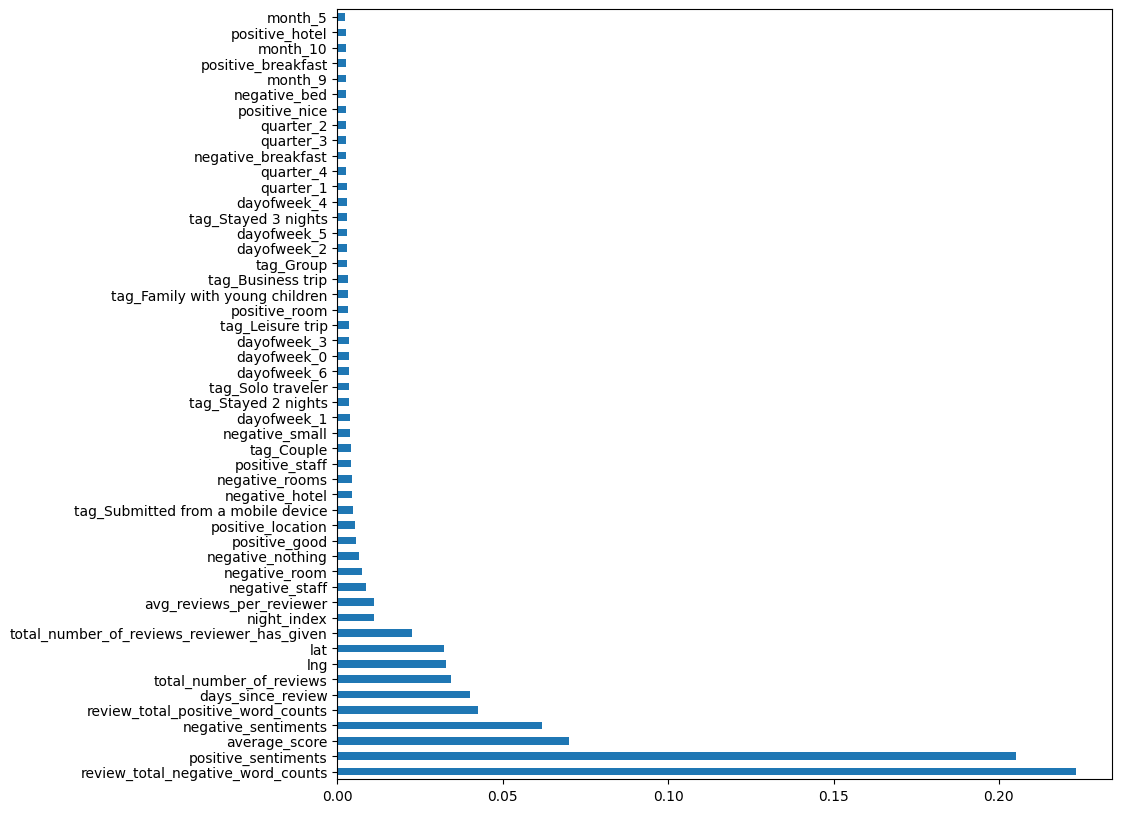

In [70]:
## в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [71]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,quarter_1,...,positive_clean,positive_excellent,positive_comfortable,positive_bed,positive_rooms,positive_lovely,positive_stay,positive_close,positive_station,positive_really
78820,-0.428571,-0.428571,2.027325,0.411765,-0.142857,-0.798295,-0.000283,-0.042450,0.0,False,...,1,0,1,0,0,0,1,0,0,0
5870,-0.142857,0.714286,-0.146819,-0.470588,-0.142857,0.491477,0.006095,-0.028493,0.0,True,...,0,0,1,0,0,0,0,0,0,0
85854,-0.428571,-0.142857,0.280995,0.294118,0.285714,-0.198864,-0.998187,3.273283,0.0,False,...,1,0,0,0,0,0,0,0,0,0
124729,-1.428571,6.190476,0.593801,0.235294,0.000000,0.161932,-3.056336,0.426203,0.0,False,...,0,0,0,0,0,0,0,0,0,0
90906,1.142857,-0.047619,0.767945,3.529412,0.428571,0.443182,-1.822201,1.842409,0.0,True,...,0,1,0,0,0,0,0,0,0,0
17246,-0.285714,-0.428571,-0.395595,0.470588,0.285714,0.096591,0.004082,-0.040765,0.0,False,...,0,0,1,1,0,0,0,0,0,0
66935,0.571429,-0.238095,0.800571,-0.411765,1.428571,-0.846591,0.267888,0.977885,0.0,False,...,0,0,0,0,0,0,0,0,0,0
22779,0.000000,1.857143,1.624388,-0.647059,5.714286,-0.116477,0.000430,-0.027263,0.0,False,...,0,0,0,0,0,0,0,0,0,0
7095,-0.571429,1.476190,0.115824,0.411765,-0.285714,0.400568,0.003638,-0.039756,0.0,True,...,0,0,0,0,0,0,0,0,0,0
18809,-2.857143,0.047619,0.057504,-0.647059,0.571429,0.227273,0.006684,-0.030554,0.0,False,...,0,0,0,0,0,0,0,0,0,0


In [72]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [73]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [74]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.2s finished


In [75]:
predict_submission

array([8.504, 7.192, 8.78 , ..., 8.015, 9.511, 7.424])

In [76]:
list(sample_submission)

['reviewer_score', 'id']

In [77]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.504,488440
1,7.192,274649
2,8.780,374688
3,9.747,404352
4,9.636,451596
5,9.001,302161
6,7.805,317079
7,7.754,13963
8,8.924,159785
9,7.400,195089
